# Ondřejov Spectra Preprocessing

This work aims to find correct preprocessing techniques for spectral data
from [Ondřejov CCD700 archive][ccd].
These preprocessing method as cleaning, balancing, scaling should help
to increase classification accuracy of a neural network.
Furthermore, it also seek to get more insight into application of machine
learning to spectral data
because there is the [LAMOST spectra survey][lamost]
which contains vast amount of unexplored data of this kind.

[ccd]: http://voarchive.asu.cas.cz/ccd700/q/web/form
[lamost]: http://www.lamost.org/public/?locale=en

The Jupyter notebook is divided into following parts.
Firstly, visualization of spectral data are presented.
Then data cleaning followed by experiments with balancing
and scaling methods.
Meanwhile, all experiments are cross validated using
neural network classifier.

In [1]:
import itertools
import numpy
import pandas
import seaborn
import tensorflow as tf
from matplotlib import pyplot
from astropy.io import fits
from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
seaborn.set_style('ticks')

## Ondřejov Dataset

Ondřejov dataset contains 12936 labeled stellar spectra from
Ondřejov CCD700 archive.
The spectra were observed with Ondřejov Perek 2m Telescope
and the observations were primarily focused on Be stars.

For complete information about the Ondřejov dataset
and corresponding code visit its [GitHub repository][dataset].

[dataset]: https://github.com/podondra/ondrejov-dataset

In [3]:
spectra = pandas.read_csv('ondrejov-dataset.csv', index_col='id')
spectra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12936 entries, a201305230017 to we200016
Columns: 151 entries, dec to 6732.0
dtypes: float64(142), int64(2), object(7)
memory usage: 15.0+ MB


### Metadata

The dataset contains some metadata from which the most interesting is
the *label* attribute:

- *id*: unique identifier (FITS file name)
- *label*: assigned class
- *object*: title of observation
- *ra*: right ascension
- *dec*: declination
- *expval*: exposure value in photon counts (Mcounts)
- *gratang*: diffraction grating angle
- *detector*: name of the detector
- *chipid*: name of CCD chip
- *specfilt*: spectral filter
- *date-obs*: UTC date start of observation
- *dichmir*: dichroic mirror number

In [4]:
spectra.iloc[:, :11].head()

,dec,gratang,detector,expval,object,dichmir,chipid,ra,specfilt,label,date-obs
id,,,,,,,,,,,
a201305230017,-11:09:40.70,30.25,PyLoN 2048x512BX,19.246130,alp Vir,2,E2V 42-10 BX,13:25:11.580,1,absorption,2013-05-23
a201306060015,+19:10:56.60,30.25,PyLoN 2048x512BX,0.009187,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060016,+19:10:56.60,30.25,PyLoN 2048x512BX,0.012332,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060018,+33:21:45.60,30.25,PyLoN 2048x512BX,5.056532,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06
a201306060019,+33:21:45.60,30.25,PyLoN 2048x512BX,15.040130,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06


Figure below shows distribution of 30 most frequent object contained in the dataset.
For example HD 91316 has more than 400 spectra in the dataset.
This might be potential problem because the spectra from an object
might be very similar so the test split should be aware of that.

There is 1306 distinct objects in the dataset.
There is 12936 different spectra in the dataset


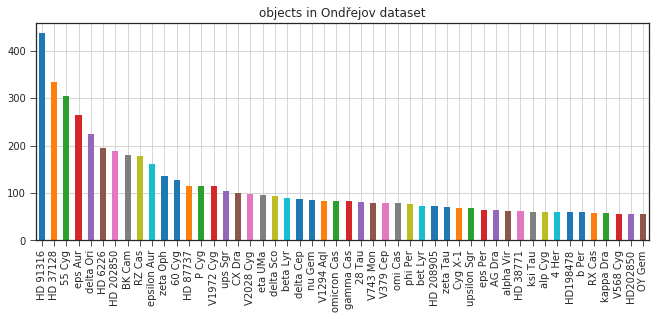

In [5]:
f, ax = pyplot.subplots(figsize=(11, 4))
ax.set_title('objects in Ondřejov dataset')
spectra['object'].value_counts().nlargest(50).plot.bar(ax=ax, grid=True)

n_objects = spectra['object'].nunique()
print('There is {} distinct objects in the dataset.'.format(n_objects))
print('There is {} different spectra in the dataset'.format(len(spectra)))

### Labels

Spectra are divided into 3 classes according to profile of
the [H-alpha spectral line][halpha].

The *absorption* in H-alpha is feature of ordinary star.
The interest is focused on the emission or double-peak star
which are rare yet unexplored objects in the universe.

[halpha]: https://en.wikipedia.org/wiki/H-alpha

For better processing the label strings are converted to numerical
value in range from 0 to 2.

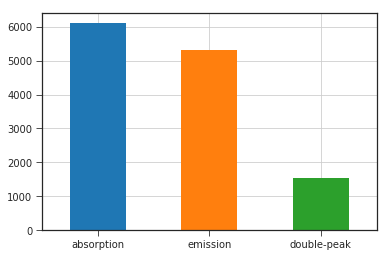

In [6]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(spectra['label'])
spectra['label'].value_counts().plot.bar(rot=0, grid=True)

### Spectral Data

Rest of dataset columns are the flux values for each spectrum.
There is exactly 140 measurement for each spectrum.
Each of the 140 features is floating point number
and they have same scale.
A useful analogy is to thing of spectrum as 1 dimensional image.
Thus, we can applied most of machine learning knowledge from image classification.
While experimenting with the dataset these column are the one
to which preprocessing method should be applied.
Therefore, the design matrix $X$ is created from them.

In [7]:
X = spectra.iloc[:, 11:].as_matrix()
X.shape

(12936, 140)

## Data Visualization

This section presents visualization of random spectra from the dataset.
A spectrum consist of fluxes at certain wavelengths.
Wavelengths are given in [Angstroms](https://en.wikipedia.org/wiki/%C3%85ngstr%C3%B6m)
and flux is a value somehow related to number of elector in each
bank of spectrograph chip.

It can be observed that the flux values significantly varies
which depends on the exposition time and other factors.
This might be a potential problem as the data were classified
according to shape at H-alpha line so the intensities should
be irrelevant.

Figures also show position vacuum H-alpha wavelength where is
the spectral line according to which the data where classified.

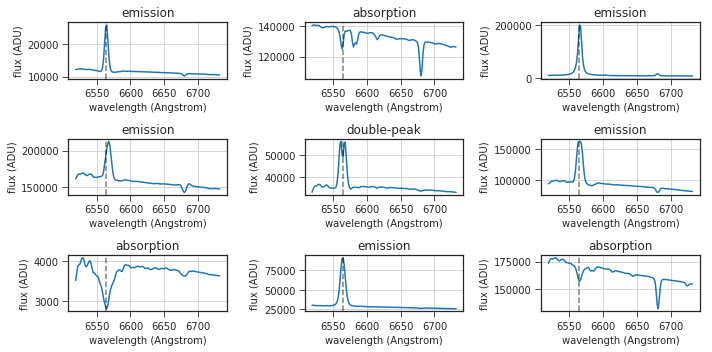

In [8]:
# http://classic.sdss.org/dr7/products/spectra/vacwavelength.html
HALPHA = 6564.614
# wavelengths from https://github.com/podondra/ondrejov-dataset
WAVES = numpy.linspace(6519, 6732, 140)

def plot_flux(flux, title=None, ax=None):
    if ax is None:
        ax = pyplot.subplot()

    ax.plot(WAVES, flux)
    ax.set_ylabel('flux (ADU)')
    ax.set_xlabel('wavelength (Angstrom)')
    ax.axvline(HALPHA, color='black', linestyle='dashed', alpha=0.5)
    ax.grid()
    
    if title is not None:
        ax.set_title(title)

nrows = 3
ncols = 3
n_idxs = nrows * ncols
rnd_idxs = numpy.random.choice(len(X), size=n_idxs, replace=False)
f, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for ax, idx in zip(axes.flat, rnd_idxs):
    plot_flux(X[idx], title=spectra.iloc[idx]['label'], ax=ax)
f.tight_layout()

Figure below compares original spectrum and corresponding spectrum
for the Ondřejov dataset.
Dataset contains only short part of the spectrum
and has much less detail.
This is due to some preprocessing techniques that are applied
during dataset creation (refer to dataset repository).
A trend can also be observed in the original spectrum
which is caused by [black-body radiation](https://en.wikipedia.org/wiki/Black-body_radiation).

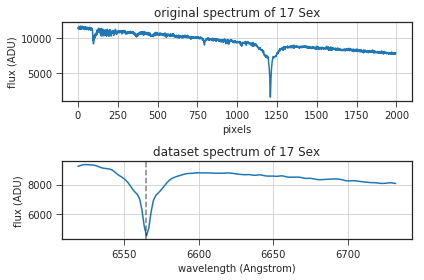

In [9]:
f, (ax1, ax2) = pyplot.subplots(nrows=2)
with fits.open('ua280060.fits') as hdulist:
    header = hdulist[0].header
    data = hdulist[0].data
    ax1.set_title('original spectrum of ' + header['OBJECT'])
    ax1.plot(data)
    ax1.set_xlabel('pixels')
    ax1.set_ylabel('flux (ADU)')
    ax1.grid()
plot_flux(
    spectra.loc['ua280060'].iloc[11:].as_matrix(),
    title='dataset spectrum of ' + spectra.loc['ua280060', 'object'],
    ax=ax2
)
f.tight_layout()

## Dimensionality Reduction

This section uses dimensionality reduction to gain insights into the data
and also to clean the data label (find incorrectly classified spectra).

### Principal Component Analysis

PCA reveals a scaling problem
because it is important to scale data when using it.
Refer to figure below which does not use scaling.
Usually each feature column is scaled separately to have unit mean
and zero variance (standardization).
But spectra features are on the same scale.
They are all from the same domain (flux in ADU).

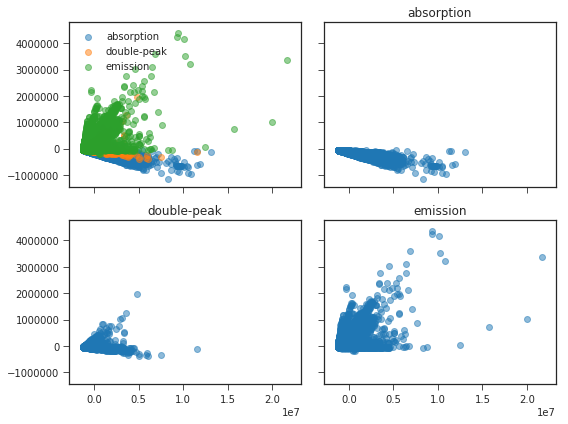

In [10]:
def plot_projection(X):
    f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(
        nrows=2, ncols=2,
        sharex=True, sharey=True,
        figsize=(8, 6)
    )

    for label, (ax, cls) in enumerate(zip((ax2, ax3, ax4), le.classes_)):
        ax1.scatter(X[y == label, 0], X[y == label, 1], label=cls, alpha=0.5)
        ax.set_title(cls)
        ax.scatter(X[y == label, 0], X[y == label, 1], alpha=0.5)
    ax1.legend(loc='upper left')

    f.tight_layout()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
plot_projection(X_pca)

The figure above much more present the intensity distribution of spectra
than their shape which is the interesting thing.
Below are two spectra selected according to position in PCA scatter plot
(shown on the right side of each spectrum).
It is clear that the two principal components depends on flux intensities.

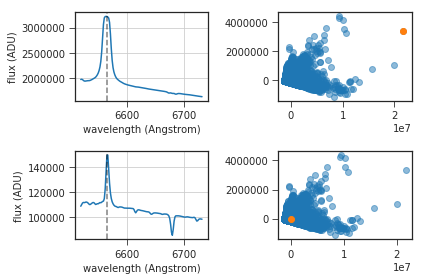

In [11]:
f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(nrows=2, ncols=2)

# spectrum far from (0, 0)
idx_high = numpy.argmax(numpy.sum(numpy.abs(X_pca[:, :2]), axis=1))
plot_flux(X[idx_high], ax=ax1)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
ax2.scatter(X_pca[idx_high, 0], X_pca[idx_high, 1])

# spectrum closes to (0, 0)
idx_low = numpy.argmin(numpy.sum(numpy.abs(X_pca[:, :2]), axis=1))
plot_flux(X[idx_low], ax=ax3)
ax4.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
ax4.scatter(X_pca[idx_low, 0], X_pca[idx_low, 1])

f.tight_layout()

Given those reason standard scaling is employed for
purpose of PCA
(for classification different method are going to be evaluated).
But since the feature are of same domain the scaling is done
to each spectrum rather than for each feature column.
Therefore the shape of spectrum is the same but the intensities are reduced.
Figures below show a random scaled spectrum in comparison to original one
from the dataset
and visualization of PCA on scaled spectra.

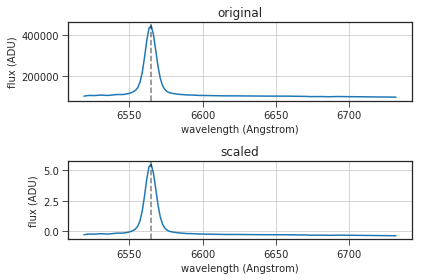

In [12]:
X_scaled = preprocessing.scale(X, axis=1)
idx = numpy.random.randint(len(X))
f, (ax1, ax2) = pyplot.subplots(nrows=2)
plot_flux(X[idx], title='original', ax=ax1)
plot_flux(X_scaled[idx], title='scaled', ax=ax2)
f.tight_layout()

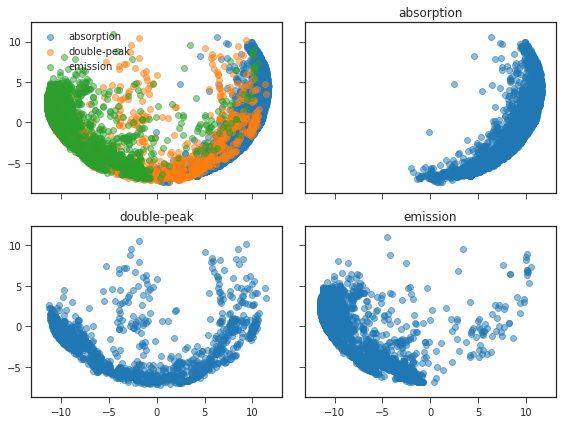

In [13]:
pca = PCA(n_components=3)
X_scaled_pca = pca.fit_transform(X_scaled)
plot_projection(X_scaled_pca)

The variant of PCA with scaling show nice properties of the dataset.
It can be inferred that it is easy to separate emission
from absorption spectra
but double-peak spectra are similar to other classes
so they are mix up with them in the scatter plot.

There is also a large portion of emission spectra in absorption
part of the scatter plot.
A visualization of them is in figure below
(all spectra with first principal component bigger than 0).
They have emission in absorption so they are interesting and in emission class
but also similar to absorption spectra.

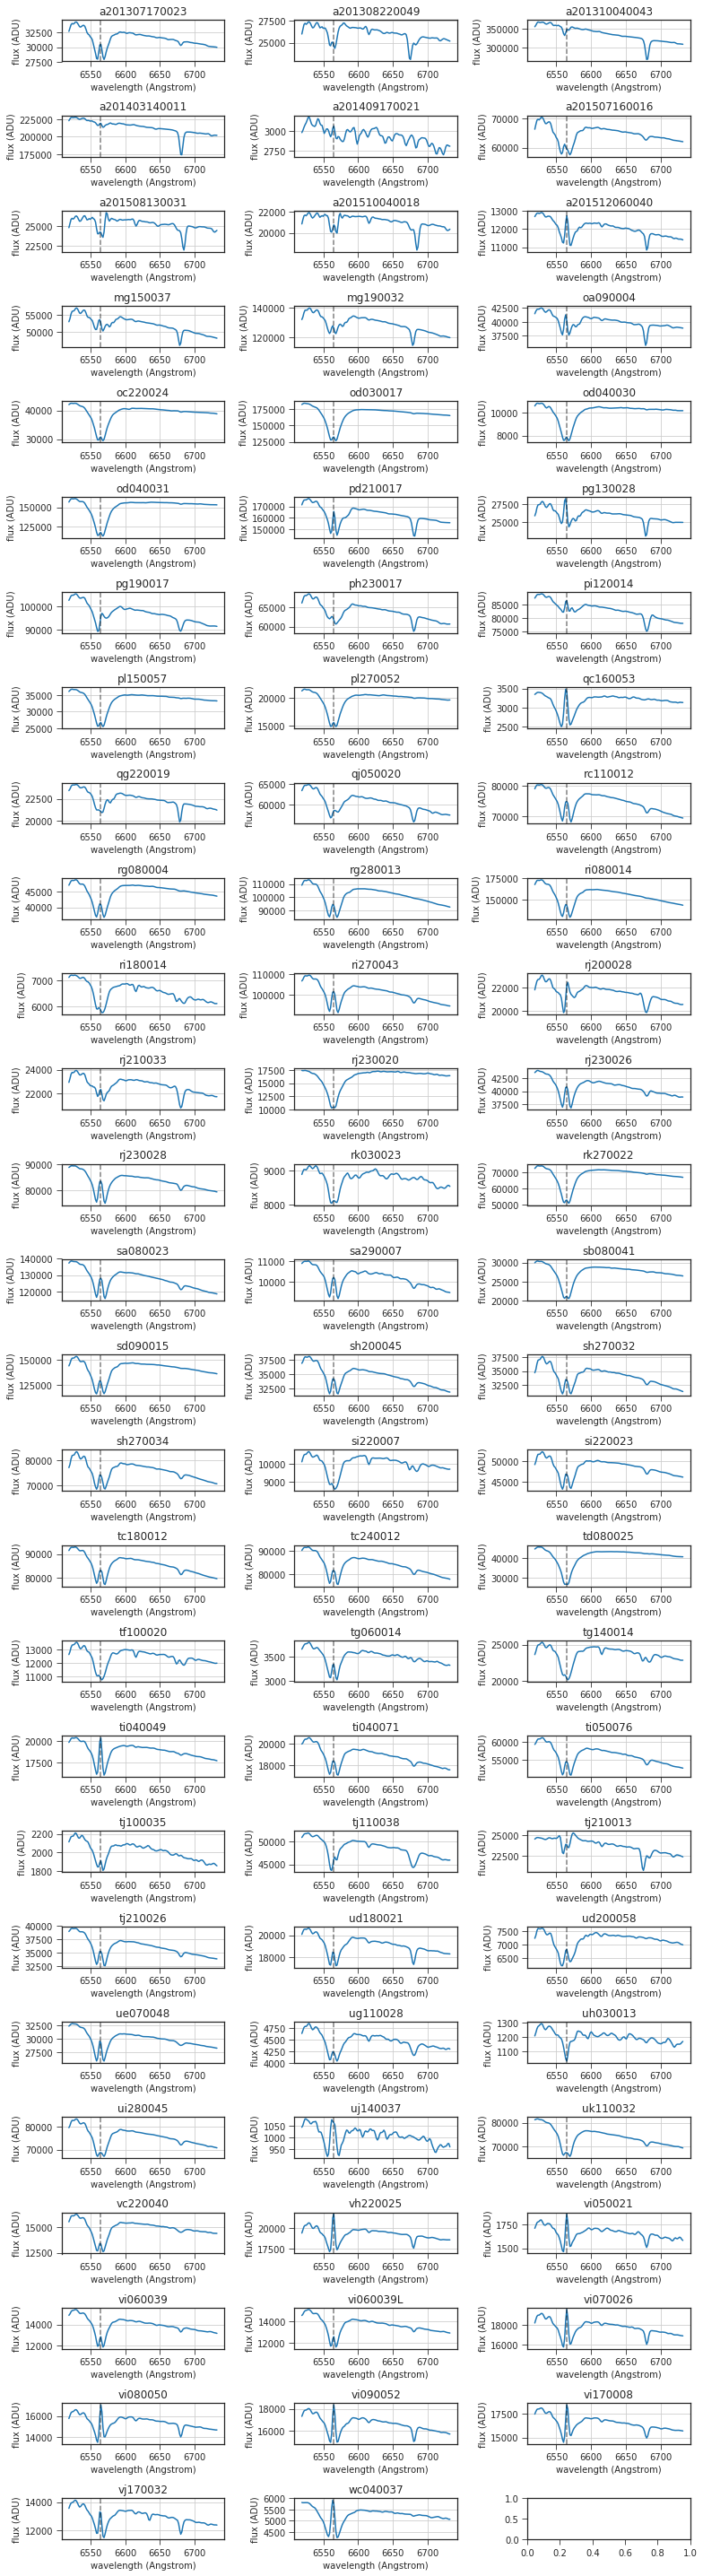

In [14]:
suspect_idxs = numpy.argwhere((y == le.transform(['emission'])) & (X_scaled_pca[:, 0] > 0)).ravel()

f, axes = pyplot.subplots(
    nrows=(len(suspect_idxs) + 1) // 3,
    ncols=3,
    figsize=(11, len(suspect_idxs) // 2)
)
for ax, idx in zip(axes.flat, suspect_idxs):
    plot_flux(X[idx], title=spectra.index[idx], ax=ax)
f.tight_layout()

### t-distributed Stochastic Neighbor Embedding

t-distributed Stochastic Neighbor Embedding ([t-SNE]) is
a technique for non-linear dimensionality reduction
from manifold learning area.
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high. ([sklearn])

[t-sne]: https://lvdmaaten.github.io/tsne/
[sklearn]: http://scikit-learn.org/stable/modules/manifold.html

In [15]:
# X_tsne = TSNE(n_components=2, verbose=1).fit_transform(
#     preprocessing.scale(X, axis=1)
# )
# plot_projection(X_tsne)

### Linear Discriminant Analysis

Supervised dimensionality reduction.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


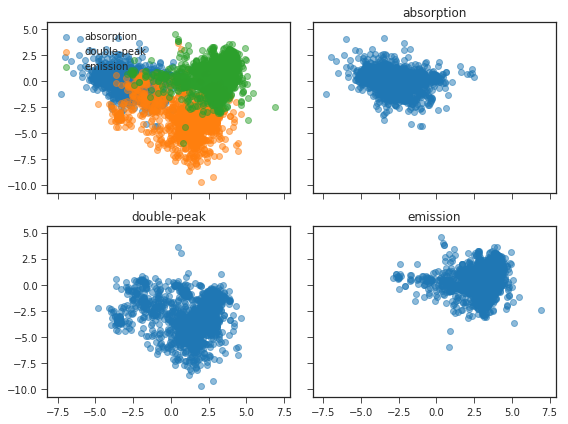

In [16]:
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(
    preprocessing.scale(X, axis=1), y
)
plot_projection(X_lda)

## Data Cleaning

Identify incorrectly classified spectra and outliers?

Describe the interactive workflow.

In [17]:
def plot_ids(ids):
    f, axes = pyplot.subplots(
        nrows=(len(ids) + 2) // 3,
        ncols=3,
        figsize=(11, 2 * ((len(ids) + 2) // 3))
    )
    for ax, i in zip(axes.flat, ids):
        idx = spectra.index == i
        plot_flux(X[idx][0], title=i, ax=ax)
    f.tight_layout()

In [18]:
# %matplotlib nbagg
# f, axes = pyplot.subplots(ncols=3, figsize=(9, 4), sharex=True, sharey=True)
# for label, (ax, cls) in enumerate(zip(axes, le.classes_)):
#     idx = y == label
#     ax.set_title(cls)
#     ax.scatter(X_lda[idx, 0], X_lda[idx, 1], label=cls, alpha=0.5)
#     for i, a, b in zip(spectra.index[idx], X_lda[idx, 0], X_lda[idx, 1]):
#         ax.annotate(i, xy=(a, b), xytext=(a, b))

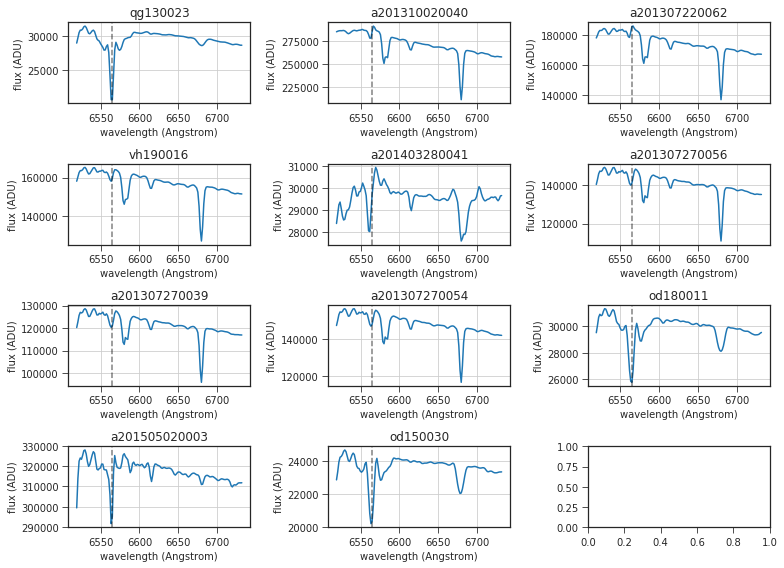

In [19]:
absorptions = [
    'qg130023', 'a201310020040', 'a201307220062',
    'vh190016', 'a201403280041', 'a201307270056',
    'a201307270039', 'a201307270054', 'od180011',
    'a201505020003', 'od150030'
]
plot_ids(absorptions)

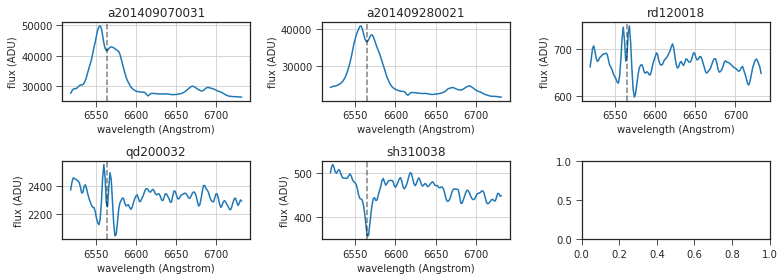

In [20]:
double_peaks = ['a201409070031', 'a201409280021', 'rd120018', 'qd200032', 'sh310038']
plot_ids(double_peaks)

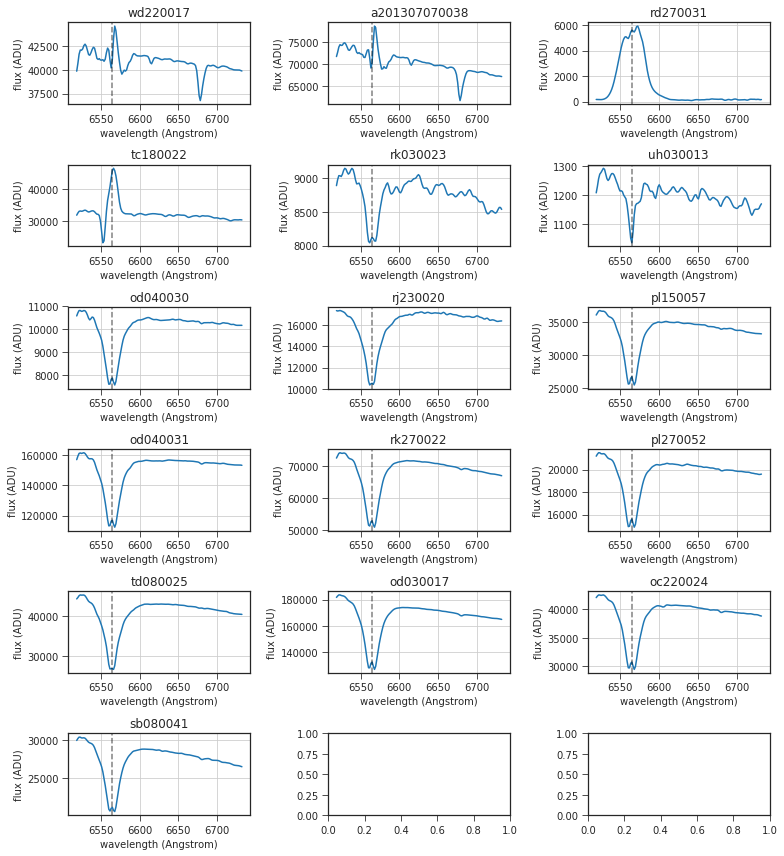

In [21]:
emissions = [
    'wd220017', 'a201307070038', 'rd270031',
    'tc180022', 'rk030023', 'uh030013',
    'od040030', 'rj230020', 'pl150057',
    'od040031', 'rk270022', 'pl270052',
    'td080025', 'od030017', 'oc220024',
    'sb080041'
]
plot_ids(emissions)

In [22]:
spectra.loc['qg130023', 'label'] = 'double-peak'
spectra.loc['od180011', 'label'] = 'double-peak'
spectra.loc['od150030', 'label'] = 'double-peak'
spectra.loc['wd220017', 'label'] = 'double-peak'
spectra.loc['a201307070038', 'label'] = 'double-peak'
spectra.loc['uh030013', 'label'] = 'absorption'

y = le.transform(spectra['label'])

## Train and Test Split

There is a specific thing to this dataset regarding train and test split.
The dataset contains spectra from same objects, for example because
some objects are observed periodically.
Figure below show 10 random spectra from 3 most common object in the dataset.
If the data were split randomly it might happen that very similar spectra
can be in both train and test set.
Therefore the data are split according to object names to avoid evaluation bias.

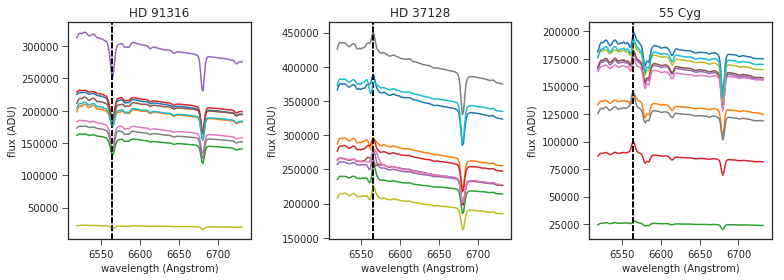

In [23]:
f, axes = pyplot.subplots(ncols=3, figsize=(11, 4))
objs = spectra['object'].value_counts().nlargest(3).index

for ax, obj in zip(axes, objs):
    ax.set_title(obj)
    all_idxs = numpy.argwhere(spectra['object'] == obj)
    rnd_idxs = numpy.random.choice(all_idxs.flat, size=10, replace=False)
    for idx in rnd_idxs:
        plot_flux(X[idx], ax=ax)

f.tight_layout()

In order to evaluate the final proposed preprocessing
procedure a test set of size 25% the original data
split out from the data.
It serves for final evaluation.
For ongoing evaluation of procedures which are about
to be tried and validation set of size 25% is taken out
of the train set with remains after the test set split.

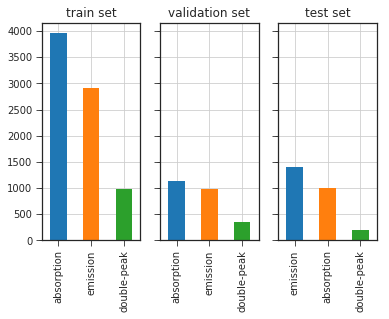

In [24]:
# seeds from TRNG https://www.random.org/
objects = spectra['object'].unique()
objects_tr, objects_te = model_selection.train_test_split(objects, random_state=15)
objects_tr, objects_va = model_selection.train_test_split(objects_tr, random_state=35)

idx_tr = spectra['object'].isin(objects_tr)
idx_va = spectra['object'].isin(objects_va)
idx_te = spectra['object'].isin(objects_te)

X_tr, y_tr = X[idx_tr], y[idx_tr]
X_va, y_va = X[idx_va], y[idx_va]
X_te, y_te = X[idx_te], y[idx_te]

f, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, sharey=True)
ax1.set_title('train set')
spectra.loc[idx_tr, 'label'].value_counts().plot.bar(grid=True, ax=ax1)
ax2.set_title('validation set')
spectra.loc[idx_va, 'label'].value_counts().plot.bar(grid=True, ax=ax2)
ax3.set_title('test set')
spectra.loc[idx_te, 'label'].value_counts().plot.bar(grid=True, ax=ax3)

## Neural Network

In [25]:
# specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column('x', shape=[140])]

# build neural network with 140 input units,
# 64 units in hidden layer
# and 3 units in output layer
# dropout: http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[64],
    n_classes=3,
    model_dir='/tmp/nn-model'
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/nn-model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f01507559e8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
# define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': X_tr},
#     x={'x': preprocessing.scale(X_tr, axis=1)},
    y=y_tr,
    num_epochs=None,
    shuffle=False
)

# train model
classifier.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/nn-model/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/nn-model/model.ckpt.
INFO:tensorflow:loss = 48885.6, step = 8001
INFO:tensorflow:global_step/sec: 318.039
INFO:tensorflow:loss = 111545.0, step = 8101 (0.316 sec)
INFO:tensorflow:global_step/sec: 325.566
INFO:tensorflow:loss = 18715.9, step = 8201 (0.306 sec)
INFO:tensorflow:global_step/sec: 345.515
INFO:tensorflow:loss = 15742.5, step = 8301 (0.292 sec)
INFO:tensorflow:global_step/sec: 323.712
INFO:tensorflow:loss = 133974.0, step = 8401 (0.306 sec)
INFO:tensorflow:global_step/sec: 298.513
INFO:tensorflow:loss = 740.69, step = 8501 (0.335 sec)
INFO:tensorflow:global_step/sec: 312.323
INFO:tensorflow:loss = 6094.85, step = 8601 (0.321 sec)
INFO:tensorflow:global_step/sec: 326.539
INFO:tensorflow:loss = 91.8564, step = 8701 (0.306 sec)
INFO:tensorflow:global_step/sec: 324.925
INFO:tensorflow:loss = 21950.5, step = 8801 

In [27]:
# define the validation inputs
validation_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': X_va},
#     x={'x': preprocessing.scale(X_va, axis=1)},
    y=y_va,
    num_epochs=1,
    shuffle=False
)

classifier.evaluate(input_fn=validation_input_fn)['accuracy']

INFO:tensorflow:Starting evaluation at 2018-01-06-13:44:03
INFO:tensorflow:Restoring parameters from /tmp/nn-model/model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-01-06-13:44:03
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.857085, average_loss = 1339.07, global_step = 10000, loss = 166312.0


0.85708535

## Scaling

Scaling to make in scale invariant as the dataset is
classified without any importance of scale.
Try different scaling methods.

## Balancing

The learning phase and the subsequent prediction of machine
learning algorithms can be affected by the problem of
imbalanced data set.
The balancing issue corresponds to the difference of the
number of samples in the different classes. ([imblearn])

[imblearn]: http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

In [28]:
# source is http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes=le.classes_, normalize=True, cmap=pyplot.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.colorbar()
    tick_marks = numpy.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=0)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('true label')
    pyplot.xlabel('predicted label')

### Random Over-sampling

The confusion matrixes are pretty much random.

In [29]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_tr, y_tr)

### Random Under-sampling

In [30]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_tr, y_tr)

### Synthetic Minority Over-sampling Technique

Synthetic Minority Over-sampling Technique ([SMOTE]) is
something.

[smote]: https://arxiv.org/abs/1106.1813

### Adaptive Synthetic Sampling Approach

Adaptive Synthetic ([ADASYN]) Sampling Approach for Imbalanced Learning.

[adasyn]: https://doi.org/10.1109/ijcnn.2008.4633969

## Remove Continuum

Try to remove trend as in time series analysis.